# Memesense Project

### Importacion de librerias

In [1]:
#import the data set from raw data
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Concatenate, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

/Users/gerardovargas/.pyenv/versions/memesense/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read the Dataset

In [2]:
df = pd.read_csv('raw_data/memotion_dataset_7k/labels.csv')

In [3]:
df.head()

Unnamed: 0    image_name  \
0           0   image_1.jpg   
1           1  image_2.jpeg   
2           2   image_3.JPG   
3           3   image_4.png   
4           4   image_5.png   

                                            text_ocr  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  The best of #10 YearChallenge! Completed in le...   
2  Sam Thorne @Strippin ( Follow Follow Saw every...   
3              10 Year Challenge - Sweet Dee Edition   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

                                      text_corrected      humour  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   hilarious   
1  The best of #10 YearChallenge! Completed in le...   not_funny   
2  Sam Thorne @Strippin ( Follow Follow Saw every...  very_funny   
3              10 Year Challenge - Sweet Dee Edition  very_funny   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   hilarious   

           sarcasm       offensive      motivational overall_sentiment  
0          general   not_offensive  not_motivational     very_positive  
1          general   not_offensive      motivational     very_positive  
2    not_sarcastic   not_offensive  not_motivational          positive  
3  twisted_meaning  very_offensive      motivational          positive  
4     very_twisted  very_offensive  not_motivational           neutral

## EDA

### Dataset Dimension

In [4]:
# Dimesion del dataset
print(df.shape)

(6992, 9)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992 entries, 0 to 6991
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         6992 non-null   int64 
 1   image_name         6992 non-null   object
 2   text_ocr           6831 non-null   object
 3   text_corrected     6987 non-null   object
 4   humour             6992 non-null   object
 5   sarcasm            6992 non-null   object
 6   offensive          6992 non-null   object
 7   motivational       6992 non-null   object
 8   overall_sentiment  6992 non-null   object
dtypes: int64(1), object(8)
memory usage: 491.8+ KB


In [6]:
# valores unicos

columns = ["humour", "sarcasm", "offensive", "motivational", "overall_sentiment"]

for col in columns:
    print(df[col].value_counts())
    print("\n")

humour
funny         2452
very_funny    2238
not_funny     1651
hilarious      651
Name: count, dtype: int64


sarcasm
general            3507
twisted_meaning    1547
not_sarcastic      1544
very_twisted        394
Name: count, dtype: int64


offensive
not_offensive        2713
slight               2592
very_offensive       1466
hateful_offensive     221
Name: count, dtype: int64


motivational
not_motivational    4525
motivational        2467
Name: count, dtype: int64


overall_sentiment
positive         3127
neutral          2201
very_positive    1033
negative          480
very_negative     151
Name: count, dtype: int64




### Data cleaning

In [7]:
df.isna().sum()

Unnamed: 0             0
image_name             0
text_ocr             161
text_corrected         5
humour                 0
sarcasm                0
offensive              0
motivational           0
overall_sentiment      0
dtype: int64

In [8]:
# drop columns text_ocr and Unnamed: 0
df_cleaned = df.drop(columns=['text_ocr', 'Unnamed: 0'], inplace=True)

In [9]:
df_cleaned = df.dropna(subset=['text_corrected'])

In [10]:
print(f"Duplicados encontrados: {df_cleaned.duplicated().sum()}")


Duplicados encontrados: 0


In [11]:
print(df_cleaned['overall_sentiment'].value_counts())


overall_sentiment
positive         3123
neutral          2200
very_positive    1033
negative          480
very_negative     151
Name: count, dtype: int64


In [13]:
df_cleaned['text_cleaned'] = df_cleaned['text_corrected'].str.lower().str.replace('[^\w\s]', '', regex=True)


/var/folders/ds/yz0jtfz15vg64w8vm3sm4mb40000gn/T/ipykernel_21401/3255724146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['text_cleaned'] = df_cleaned['text_corrected'].str.lower().str.replace('[^\w\s]', '', regex=True)


In [14]:
# Eliminar filas donde el texto esté vacío
df_cleaned = df_cleaned[df_cleaned['text_cleaned'].str.strip() != ""]

In [15]:
df_cleaned.head()

image_name                                     text_corrected  \
0   image_1.jpg  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  image_2.jpeg  The best of #10 YearChallenge! Completed in le...   
2   image_3.JPG  Sam Thorne @Strippin ( Follow Follow Saw every...   
3   image_4.png              10 Year Challenge - Sweet Dee Edition   
4   image_5.png  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

       humour          sarcasm       offensive      motivational  \
0   hilarious          general   not_offensive  not_motivational   
1   not_funny          general   not_offensive      motivational   
2  very_funny    not_sarcastic   not_offensive  not_motivational   
3  very_funny  twisted_meaning  very_offensive      motivational   
4   hilarious     very_twisted  very_offensive  not_motivational   

  overall_sentiment                                       text_cleaned  
0     very_positive  look there my friend lightyear now all sohalik...  
1     very_positive  the best of 10 yearchallenge completed in less...  
2          positive  sam thorne strippin  follow follow saw everyon...  
3          positive               10 year challenge  sweet dee edition  
4           neutral  10 year challenge with no filter 47 hilarious ...

In [16]:
df_cleaned.isna().sum()

image_name           0
text_corrected       0
humour               0
sarcasm              0
offensive            0
motivational         0
overall_sentiment    0
text_cleaned         0
dtype: int64

In [17]:
df_cleaned.drop(columns=['text_corrected'], inplace=True)

In [18]:
#reemplazar de la columna overall_sentiment very_positive por positive y very_negative por negative
df_cleaned['overall_sentiment'] = df_cleaned['overall_sentiment'].replace('very_positive', 'positive')
df_cleaned['overall_sentiment'] = df_cleaned['overall_sentiment'].replace('very_negative', 'negative')

In [19]:
df_cleaned.head()

image_name      humour          sarcasm       offensive  \
0   image_1.jpg   hilarious          general   not_offensive   
1  image_2.jpeg   not_funny          general   not_offensive   
2   image_3.JPG  very_funny    not_sarcastic   not_offensive   
3   image_4.png  very_funny  twisted_meaning  very_offensive   
4   image_5.png   hilarious     very_twisted  very_offensive   

       motivational overall_sentiment  \
0  not_motivational          positive   
1      motivational          positive   
2  not_motivational          positive   
3      motivational          positive   
4  not_motivational           neutral   

                                        text_cleaned  
0  look there my friend lightyear now all sohalik...  
1  the best of 10 yearchallenge completed in less...  
2  sam thorne strippin  follow follow saw everyon...  
3               10 year challenge  sweet dee edition  
4  10 year challenge with no filter 47 hilarious ...

In [20]:
import os

image_folder = 'raw_data/memotion_dataset_7k/images/'

# Verificar imágenes existentes
df_cleaned['image_exists'] = df_cleaned['image_name'].apply(lambda x: os.path.exists(os.path.join(image_folder, x)))

# Filtrar solo las filas con imágenes válidas
df_cleaned = df_cleaned[df_cleaned['image_exists']]

df_cleaned.head()


image_name      humour          sarcasm       offensive  \
0   image_1.jpg   hilarious          general   not_offensive   
1  image_2.jpeg   not_funny          general   not_offensive   
2   image_3.JPG  very_funny    not_sarcastic   not_offensive   
3   image_4.png  very_funny  twisted_meaning  very_offensive   
4   image_5.png   hilarious     very_twisted  very_offensive   

       motivational overall_sentiment  \
0  not_motivational          positive   
1      motivational          positive   
2  not_motivational          positive   
3      motivational          positive   
4  not_motivational           neutral   

                                        text_cleaned  image_exists  
0  look there my friend lightyear now all sohalik...          True  
1  the best of 10 yearchallenge completed in less...          True  
2  sam thorne strippin  follow follow saw everyon...          True  
3               10 year challenge  sweet dee edition          True  
4  10 year challenge with no filter 47 hilarious ...          True

## Preprocessing

### Preprocessing Images

In [22]:
import cv2
image_folder = 'raw_data/memotion_dataset_7k/images/'

# Función para procesar imágenes
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Carga, redimensiona y normaliza una imagen.
    """
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir a RGB
        img = cv2.resize(img, target_size)  # Redimensionar
        img = img / 255.0  # Normalizar
    return img

# Procesar imágenes
images = []
labels = []
for idx, row in df_cleaned.iterrows():
    image_path = os.path.join(image_folder, row['image_name'])
    if os.path.exists(image_path):
        img = preprocess_image(image_path)
        if img is not None:
            images.append(img)
            labels.append(row['overall_sentiment'])  # Etiqueta del sentimiento general

# Convertir a numpy array
images = np.array(images)
print(f"Imágenes procesadas: {images.shape}")

libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng error: Read Error
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Imágenes procesadas: (6983, 224, 224, 3)


### Preprocessing Text

In [23]:
# Cargar el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizar el texto
max_len = 50
text_encodings = tokenizer(list(df_cleaned['text_cleaned']), truncation=True, padding=True, max_length=max_len, return_tensors="tf")


### Conversion de Etiquetas

In [24]:
# Codificación de etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Convertir etiquetas a números
print(f"Etiquetas codificadas: {len(set(y))}")


Etiquetas codificadas: 3


### Split the data

In [63]:
min_samples,len(images)

(6983, 6983)

In [ ]:
from sklearn.model_selection import train_test_split

# Check the shapes of the arrays
print(f"Shape of images: {images.shape}")
print(f"Shape of text encodings: {text_encodings['input_ids'].shape}")
print(f"Shape of labels: {y.shape}")

# Ensure all arrays have the same number of samples
min_samples = min(len(images), len(text_encodings['input_ids']), len(y))
images = images[:min_samples]
text_encodings['input_ids'] = text_encodings['input_ids'][:min_samples]
text_encodings['attention_mask'] = text_encodings['attention_mask'][:min_samples]
y = y[:min_samples]

# Split images and labels
X_train_images, X_test_images, y_train, y_test = train_test_split(
    images, y, test_size=0.2, random_state=42
)

# Split text encodings and attention masks
text_data_train, text_data_test, attention_mask_train, attention_mask_test = train_test_split(
    text_encodings['input_ids'].numpy(), text_encodings['attention_mask'].numpy(), test_size=0.2, random_state=42
)

# Convert back to tensors
text_data_train = tf.convert_to_tensor(text_data_train)
text_data_test = tf.convert_to_tensor(text_data_test)
attention_mask_train = tf.convert_to_tensor(attention_mask_train)
attention_mask_test = tf.convert_to_tensor(attention_mask_test)

print(f"Conjunto de entrenamiento - Imágenes: {X_train_images.shape}, Texto: {text_data_train.shape}")
print(f"Conjunto de prueba - Imágenes: {X_test_images.shape}, Texto: {text_data_test.shape}")


Shape of images: (6983, 224, 224, 3)
Shape of text encodings: (6983, 50)
Shape of labels: (6983,)
Conjunto de entrenamiento - Imágenes: (5586, 224, 224, 3), Texto: (5586, 50)
Conjunto de prueba - Imágenes: (1397, 224, 224, 3), Texto: (1397, 50)


In [61]:
print(attention_mask_test)

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(1397, 50), dtype=int32)


In [35]:
#import pickle

# Guardar el tokenizador
#with open('tokenizer.pkl', 'wb') as f:
#    pickle.dump(tokenizer, f)

# Guardar el label encoder
#with open('label_encoder.pkl', 'wb') as f:
#    pickle.dump(label_encoder, f)

In [31]:
# Verificar las primeras imágenes
print(f"Primeras imágenes procesadas:\n {X_train_images[:2]}")

# Verificar las primeras secuencias de texto
print(f"Primeras secuencias de texto procesadas:\n {text_data_train[:2]}")

# Verificar las primeras etiquetas
print(f"Primeras etiquetas:\n {y_train[:2]}")


Primeras imágenes procesadas:
 [[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.        

### Multimodal Model

Using:
- CNN (Convolutional Neural Network): For processing images.
- LSTM (Long Short-Term Memory): For processing text.
- Concatennate: To combined both outputs in a Dense cape.

In [ ]:
from tensorflow.keras.applications import ResNet50

# Entrada para imágenes
image_input = Input(shape=(224, 224, 3), name="Image_Input")
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))(image_input)
resnet_out = GlobalAveragePooling2D()(resnet_base)

# Entrada para texto (usando BERT)
text_input_ids = Input(shape=(max_len,), dtype=tf.int32, name="Text_Input_Ids")
text_attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="Text_Attention_Mask")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
class BertLayer(tf.keras.layers.Layer):
	def __init__(self, **kwargs):
		super(BertLayer, self).__init__(**kwargs)
		self.bert = TFBertModel.from_pretrained('bert-base-uncased')

	def call(self, inputs):
		input_ids, attention_mask = inputs
		outputs = self.bert(input_ids, attention_mask=tf.cast(attention_mask, tf.float32))
		return outputs[1]  # Usamos el "pooler output"

bert_layer = BertLayer()
bert_out = bert_layer([text_input_ids, text_attention_mask])

combined = Concatenate()([resnet_out, bert_out])
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(set(y_train)), activation='softmax')(x)

# Crear el modelo
model = Model(inputs=[image_input, text_input_ids, text_attention_mask], outputs=output)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image_Input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ Image_Input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Text_Input_Ids      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Text_Attention_Mask │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 768)       │          0 │ Text_Input_Ids[0… │
│ (BertLayer)         │                   │            │ Text_Attention_M… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2816)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ bert_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    721,152 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        387 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,342,147 (92.86 MB)

 Trainable params: 24,289,027 (92.66 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Model Fit

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# Ensure the model is built
model.build(input_shape=[
    (None, 224, 224, 3),  # Shape for image input
    (None, max_len),      # Shape for text input ids
    (None, max_len)       # Shape for text attention mask
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    [X_train_images, text_data_train, attention_mask_train],
    y_train,
    validation_data=([X_test_images, text_data_test, attention_mask_test], y_test),
    epochs=20,
    batch_size=32, callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.5323 - loss: 1.0195 - val_accuracy: 0.5870 - val_loss: 2.7200
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 480s 3s/step - accuracy: 0.5912 - loss: 0.8767 - val_accuracy: 0.5691 - val_loss: 0.9341
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.6480 - loss: 0.7712 - val_accuracy: 0.5698 - val_loss: 0.9165
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.7370 - loss: 0.6110 - val_accuracy: 0.5619 - val_loss: 1.1142
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.8466 - loss: 0.4037 - val_accuracy: 0.5605 - val_loss: 1.5928
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.8925 - loss: 0.2947 - val_accuracy: 0.5462 - val_loss: 1.9009


In [42]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate([X_test_images, text_data_test, attention_mask_test], y_test)
print(f"Pérdida en prueba: {test_loss}")
print(f"Precisión en prueba: {test_accuracy}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 769ms/step - accuracy: 0.5619 - loss: 0.9090
Pérdida en prueba: 0.9165425300598145
Precisión en prueba: 0.5697923898696899


### Prediction with new Data

In [59]:
# Nuevas imágenes y texto preprocesados
nuevas_imagenes = X_test_images[:20]  # Ejemplo: 5 imágenes del conjunto de prueba
nuevos_textos = text_data_test[:20]  # Ejemplo: 5 textos del conjunto de prueba
nuevas_mascaras = attention_mask_test[:20]  # Ejemplo: 5 máscaras de atención del conjunto de prueba

# Predicción
predicciones = model.predict([nuevas_imagenes, nuevos_textos, nuevas_mascaras])
clases_predichas = predicciones.argmax(axis=1)

# Decodificar etiquetas
clases_decodificadas = label_encoder.inverse_transform(clases_predichas)
print(f"Clases predichas: {clases_decodificadas}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Clases predichas: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'neutral' 'positive' 'positive' 'positive' 'neutral'
 'positive' 'positive' 'neutral' 'positive' 'positive' 'positive'
 'positive' 'positive']


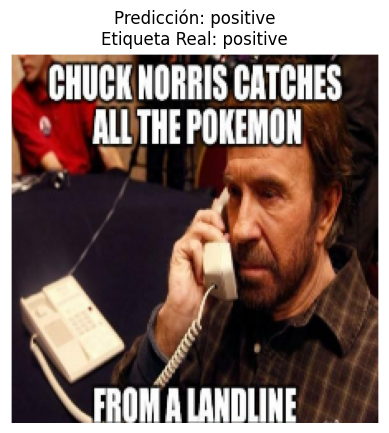

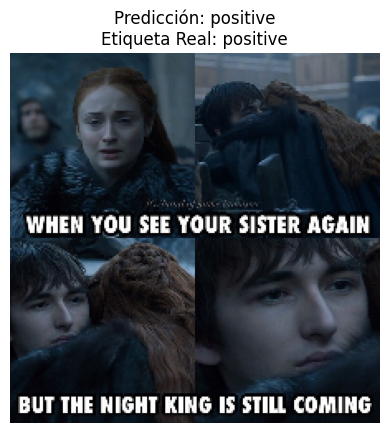

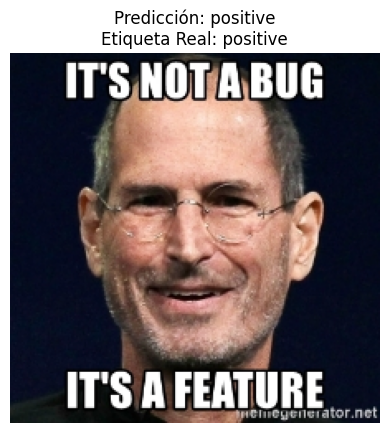

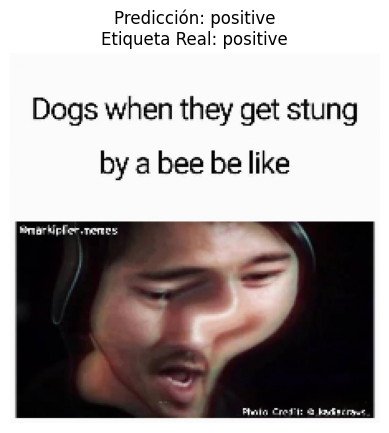

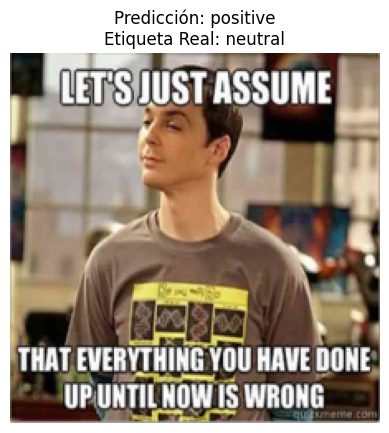

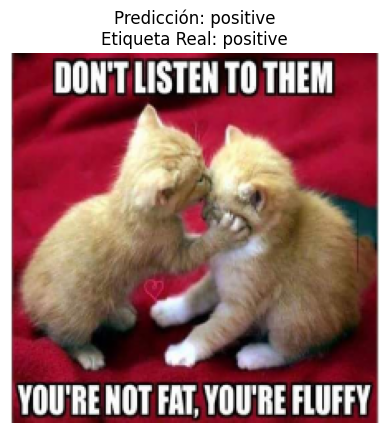

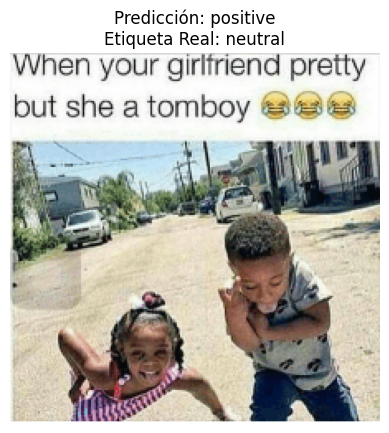

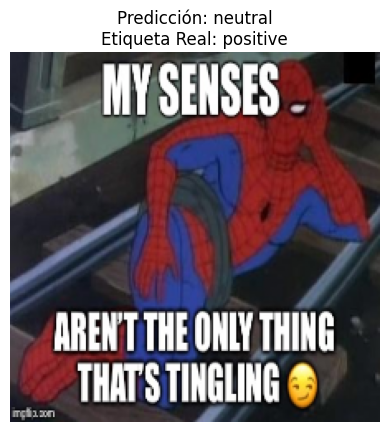

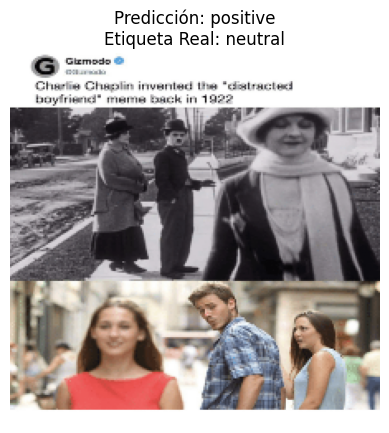

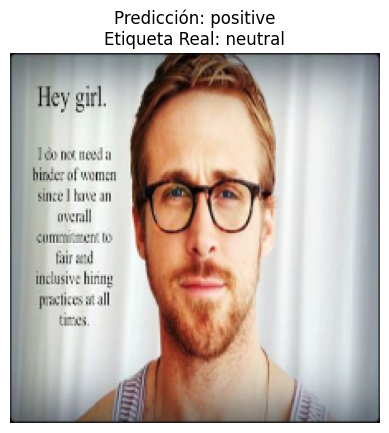

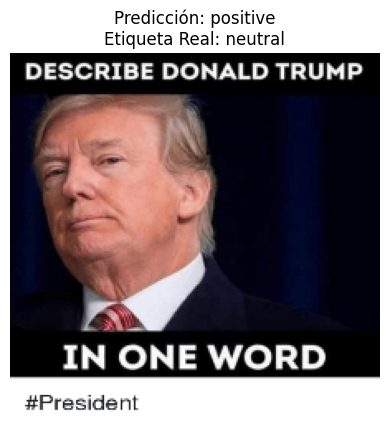

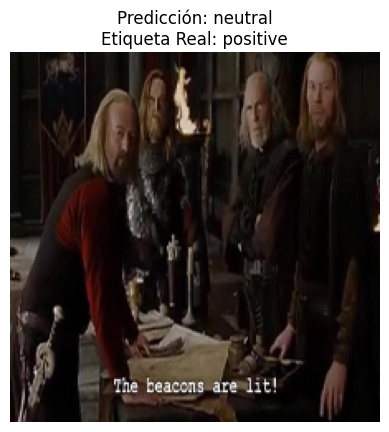

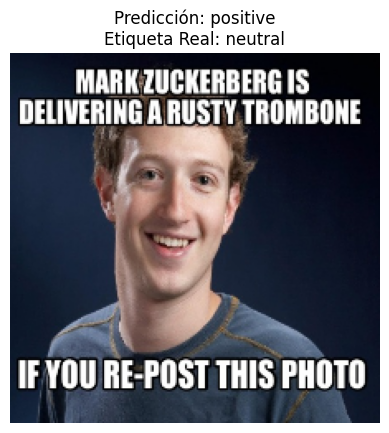

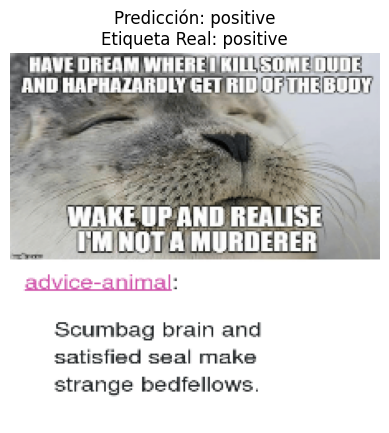

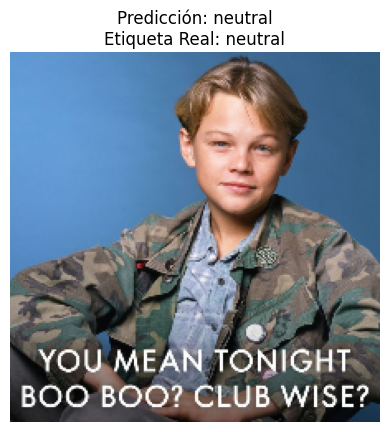

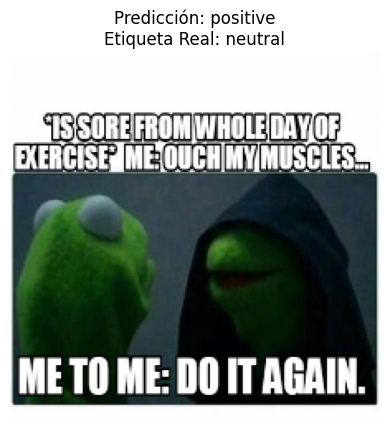

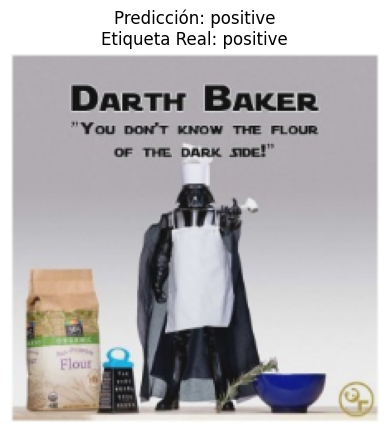

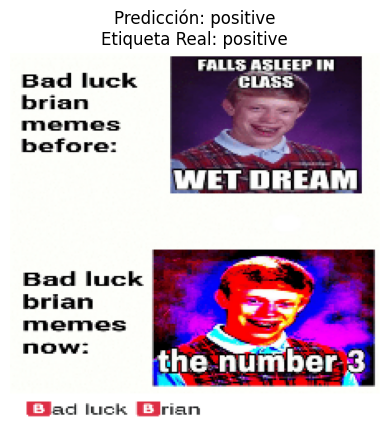

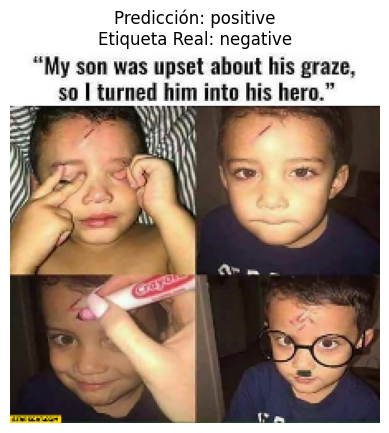

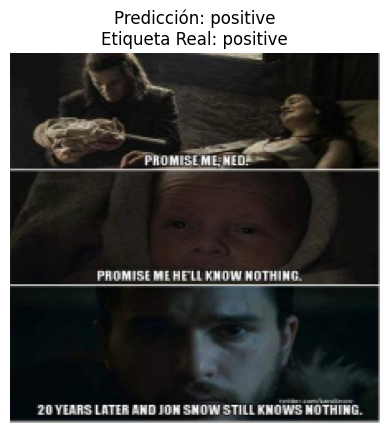

In [60]:
import matplotlib.pyplot as plt

for i in range(20):  # Mostrar 5 ejemplos
    plt.imshow(X_test_images[i])
    plt.axis('off')
    plt.title(f"Predicción: {clases_decodificadas[i]}\nEtiqueta Real: {label_encoder.inverse_transform([y_test[i]])[0]}")
    plt.show()

In [48]:
# Guardar el modelo
model.save('modelo_multimodal.h5')

# Cargar el modelo en el futuro
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# Ensure BertLayer is registered
with custom_object_scope({'BertLayer': BertLayer}):
	modelo_cargado = load_model('modelo_multimodal.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 772ms/step


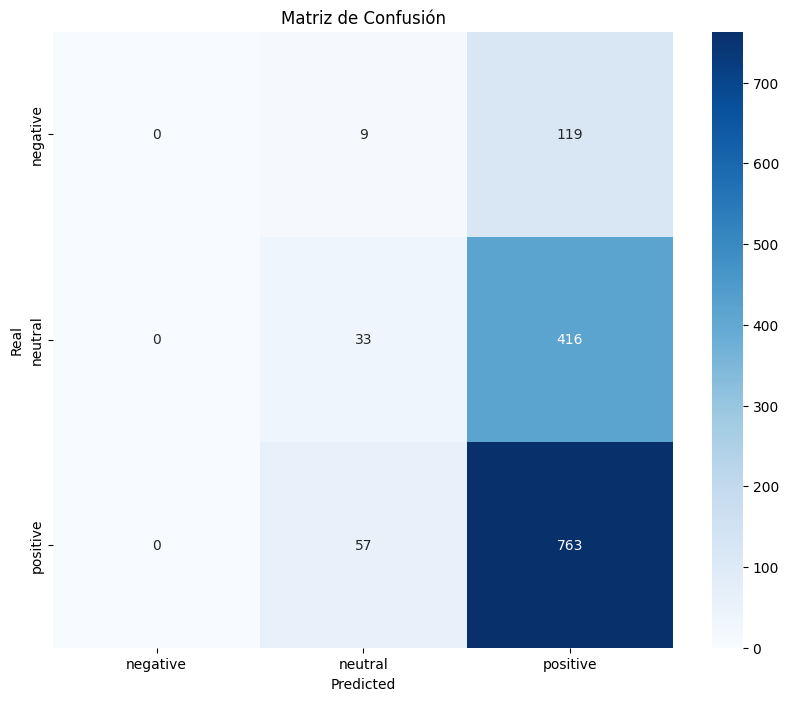

In [50]:
# matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# Ensure BertLayer is registered
with custom_object_scope({'BertLayer': BertLayer}):
	modelo_cargado = load_model('modelo_multimodal.h5')

# Predicciones en el conjunto de prueba
predictions = modelo_cargado.predict([X_test_images, text_data_test, attention_mask_test])
class_predict = predictions.argmax(axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, class_predict)

# Etiquetas
labels = label_encoder.classes_

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()




In [52]:
# Reporte de clasificación
from sklearn.metrics import classification_report

# Predicciones en el conjunto de prueba
predicciones_completas = model.predict([X_test_images, text_data_test, attention_mask_test])
clases_predichas_completas = predicciones_completas.argmax(axis=1)

# Reporte de clasificación
print(classification_report(y_test, clases_predichas_completas, target_names=labels))

44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 810ms/step
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       128
     neutral       0.33      0.07      0.12       449
    positive       0.59      0.93      0.72       820

    accuracy                           0.57      1397
   macro avg       0.31      0.33      0.28      1397
weighted avg       0.45      0.57      0.46      1397



/Users/gerardovargas/.pyenv/versions/memesense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerardovargas/.pyenv/versions/memesense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerardovargas/.pyenv/versions/memesense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av